Here, we have data for NVE simulations of rigid bumpy particles of various $\mu_{eff}$ and $N_v$ across a range of $\phi$, starting at a dilute region and going beyond jamming.  Each NVE run is performed consecutively, starting from the lowest $\phi$ and incrementally compressing using a simple rescaling thermostat to enforce the temperature.  The particles are compressed and thermostatted for $N_{steps}/20$ and are allowed to thermally equilibrate under the thermostat for another $N_{steps}/20$.  Following this, the thermostat is turned off, and the NVE dynamics progress for $N_{steps}$.  We then measure the translational and rotational diffusion coefficients (using the MSD and MSAD), the structural relaxation times (using the self-part of the ISF and the rotational ISF), and the location of the first peak in the radial distribution function.  The measurements were performed in the Hard Particle (HP) limit, such that time-dependent quantities can be simply rescaled by $t \sqrt{T}$.

There are two sets of runs here.  One was performed at a higher temperature (I believe, $T=10^{-4}$) using the old method for calculating the moment of inertia.  The other was at $T=10^{-6}$ and uses the new method for the moment of inertia.  The new data is the one to pay attention to.

Here, we will plot the $\phi$, $\mu_{eff}$, and $N_v$ dependence of the dynamic and structural quantities of interest.

In [224]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])


In [65]:
root = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/'

hot_dir = os.path.join(root, 'rb-compression-diffusion')
cold_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp')

In [124]:
# measure pressure?


In [306]:
# dirname = hot_dir
# dt = 1e-2
# T = 1e-4
dirname = cold_dir
dt = 5e-2
T = 1e-6

system_data = {
    'phi': [],
    'D': [],
    'n': [],
    'R2': [],
    'D_R': [],
    'n_R': [],
    'R2_R': [],
    'tau_small': [],
    'tau_R_small': [],
    'tau_large': [],
    'tau_R_large': [],
    'r0_small': [],
    'r0_large': [],
    'nv': [],
    'mu_eff': [],
}

for friction_coefficient in os.listdir(dirname):
    friction_dir = os.path.join(dirname, friction_coefficient)
    file_index = 0
    while os.path.exists(run_path := os.path.join(friction_dir, f'dynamics_{file_index}')):
        file_index += 1
        data = dp.data.load(run_path, location=['final', 'init'])
        data.calculate_mu_eff()

        m = data.final.msd[:, :, 0]
        am = data.final.msd[:, :, 1]
        isf_small = data.final.isf[:, 0, :]
        isf_large = data.final.isf[:, 1, :]
        aisf_small = data.final.angular_isf[:, 0, :]
        aisf_large = data.final.angular_isf[:, 1, :]
        t = data.final.t * dt * np.sqrt(T)
        g_small = data.final.g[:, 0, :].T
        g_large = data.final.g[:, 1, :].T
        r = data.final.r

        for sid in range(data.n_systems()):
            _m = m[:, sid]
            D, n, R2 = fit_log(t, _m, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
            # plt.plot(t, _m)
            # plt.plot(t, D * t ** 1)

            _am = am[:, sid]
            D_R, n_R, R2_R = fit_log(t, _am, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
            # plt.plot(t, _am)
            # plt.plot(t, D_R * t ** 1)

            _isf_small = isf_small[:, sid]
            tau_small = get_relaxation_time(_isf_small, t)
            # plt.plot(t, _isf)
            # plt.axvline(tau, color='k', linestyle='--')

            _isf_large = isf_large[:, sid]
            tau_large = get_relaxation_time(_isf_large, t)
            # plt.plot(t, _isf_large)
            # plt.axvline(tau_large, color='k', linestyle='--')
            # use tau to override D (if it is nan, D is nan)
            if np.isnan(tau_small) or np.isnan(tau_large):
                D = np.nan

            _aisf_small = aisf_small[:, sid]
            tau_R_small = get_relaxation_time(_aisf_small, t)
            # plt.plot(t, _aisf)
            # plt.axvline(tau_R, color='k', linestyle='--')

            _aisf_large = aisf_large[:, sid]
            tau_R_large = get_relaxation_time(_aisf_large, t)
            # plt.plot(t, _aisf_large)
            # plt.axvline(tau_R_large, color='k', linestyle='--')

            # use tau_R to override D_R (if it is nan, D_R is nan)
            if np.isnan(tau_R_small) or np.isnan(tau_R_large):
                D_R = np.nan

            _g_small = g_small[:, sid]
            r0_small = get_peak_location(r, _g_small, window_pct=0.99)
            # plt.plot(r, _g_small)
            # plt.scatter(r0_small, np.max(_g_small), color='k')

            _g_large = g_large[:, sid]
            r0_large = get_peak_location(r, _g_large, window_pct=0.99)
            # plt.plot(r, _g_large)
            # plt.scatter(r0_large, np.max(_g_large), color='k')

            system_data['phi'].append(data.packing_fraction[sid])
            system_data['D'].append(D)
            system_data['n'].append(n)
            system_data['R2'].append(R2)
            system_data['D_R'].append(D_R)
            system_data['n_R'].append(n_R)
            system_data['R2_R'].append(R2_R)
            system_data['tau_small'].append(tau_small)
            system_data['tau_R_small'].append(tau_R_small)
            system_data['tau_large'].append(tau_large)
            system_data['tau_R_large'].append(tau_R_large)
            system_data['r0_small'].append(r0_small)
            system_data['r0_large'].append(r0_large)
            system_data['nv'].append(data.n_vertices_per_particle[data.system_offset[sid]])
            system_data['mu_eff'].append(data.mu_eff[data.system_offset[sid]])
system_data = pd.DataFrame(system_data)

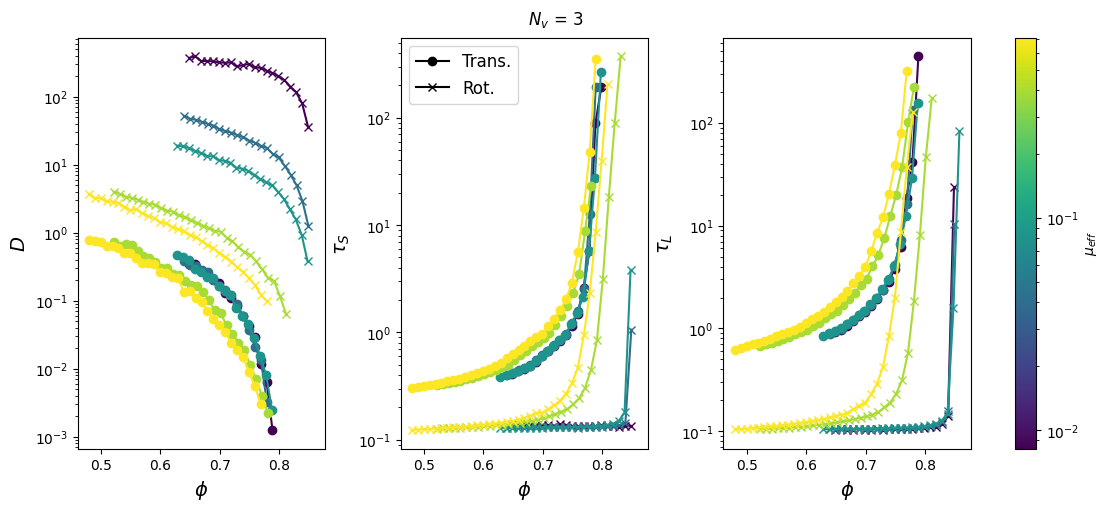

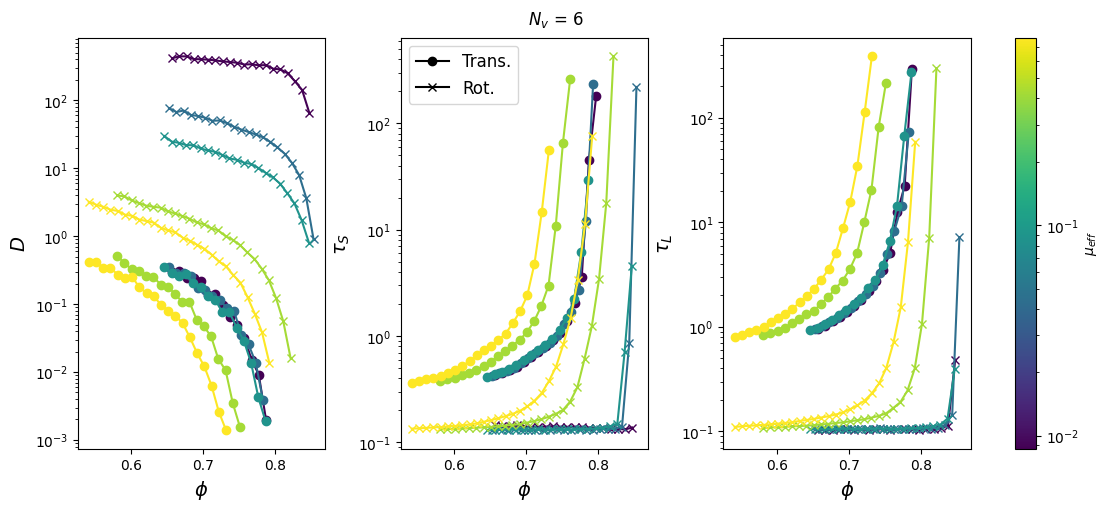

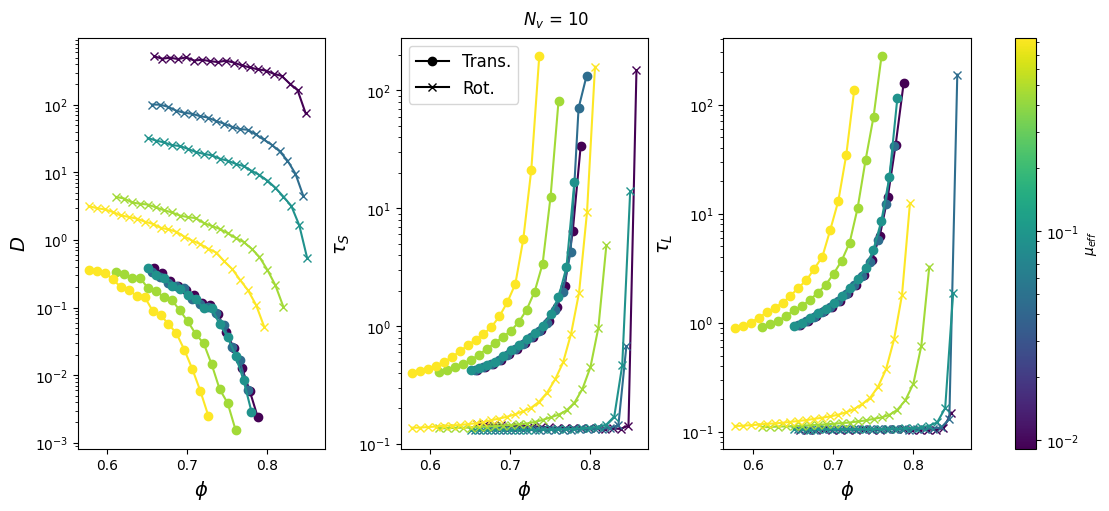

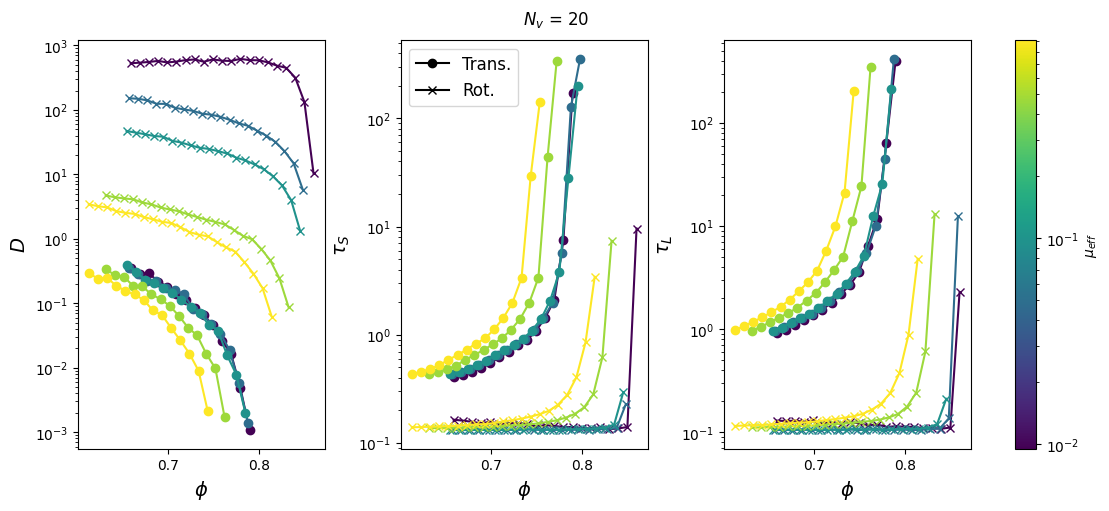

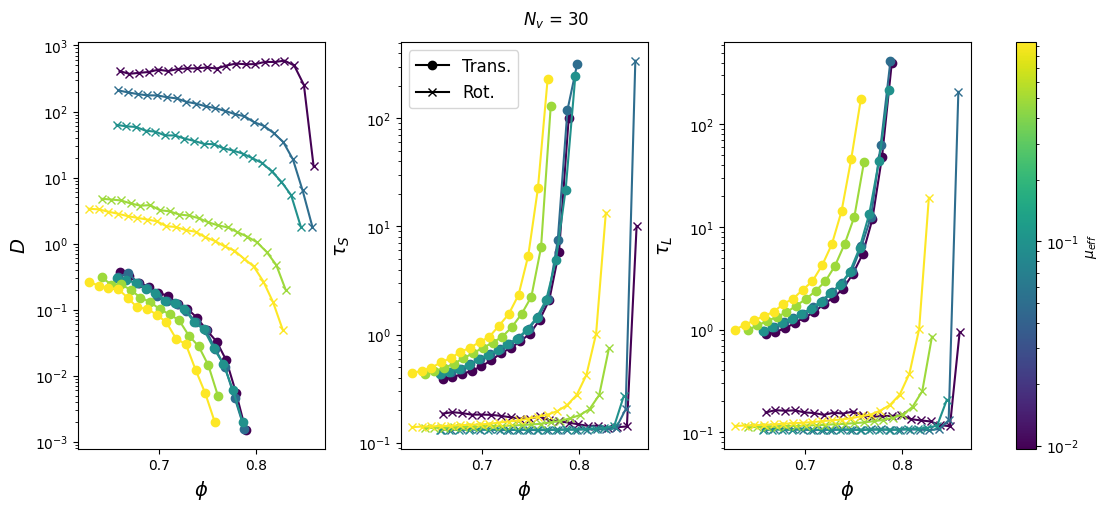

In [307]:
for nv in np.unique(system_data.nv):
    mask = system_data.nv == nv
    mu_eff_values = np.unique(system_data[mask].mu_eff)

    cmap = plt.get_cmap('viridis')
    mu_eff_norm = LogNorm(vmin=mu_eff_values.min(), vmax=mu_eff_values.max())

    fig, ax = plt.subplots(1, 3, figsize=(11, 5), constrained_layout=True, sharex=True)
    for mu_eff in mu_eff_values:
        mask2 = mask & (system_data.mu_eff == mu_eff)
        ax[0].plot(system_data.phi[mask2], system_data.D[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[0].plot(system_data.phi[mask2], system_data.D_R[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='x')
        # ax[0].plot(system_data.phi[mask2], system_data.R2_R[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='x')  # KEEP IN MIND R2!

        ax[1].plot(system_data.phi[mask2], system_data.tau_small[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[1].plot(system_data.phi[mask2], system_data.tau_R_small[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='x')

        ax[2].plot(system_data.phi[mask2], system_data.tau_large[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[2].plot(system_data.phi[mask2], system_data.tau_R_large[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='x')
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$D$', fontsize=14)
    ax[1].set_ylabel(r'$\tau_S$', fontsize=14)
    ax[2].set_ylabel(r'$\tau_L$', fontsize=14)

    ax[1].get_shared_y_axes().joined(ax[1], ax[2])  # join the y-axes of ax[1] and ax[2]

    ax[1].plot([], [], c='k', marker='o', label='Trans.')
    ax[1].plot([], [], c='k', marker='x', label='Rot.')
    ax[1].legend(fontsize=12)

    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.savefig(f'figures/dynamics/{nv-1}.png', dpi=300)
    plt.show()


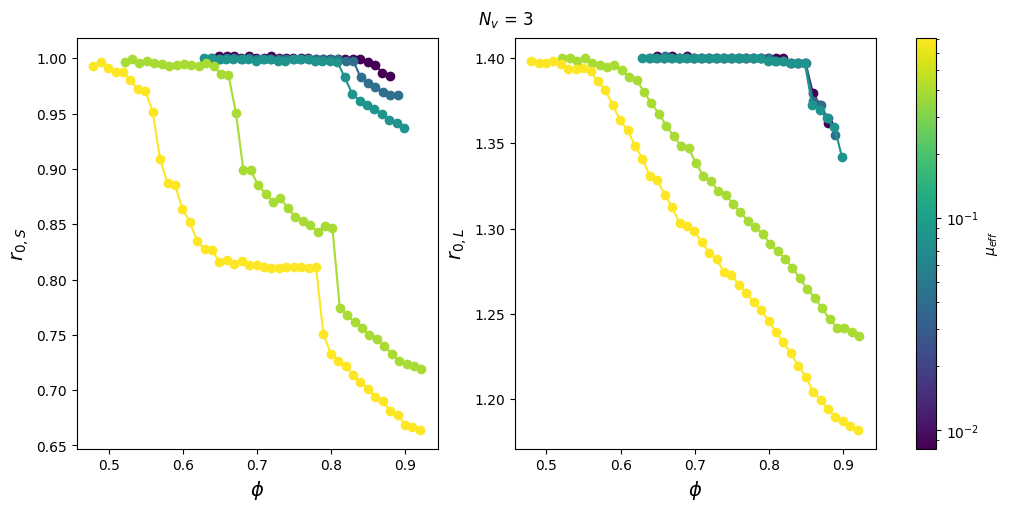

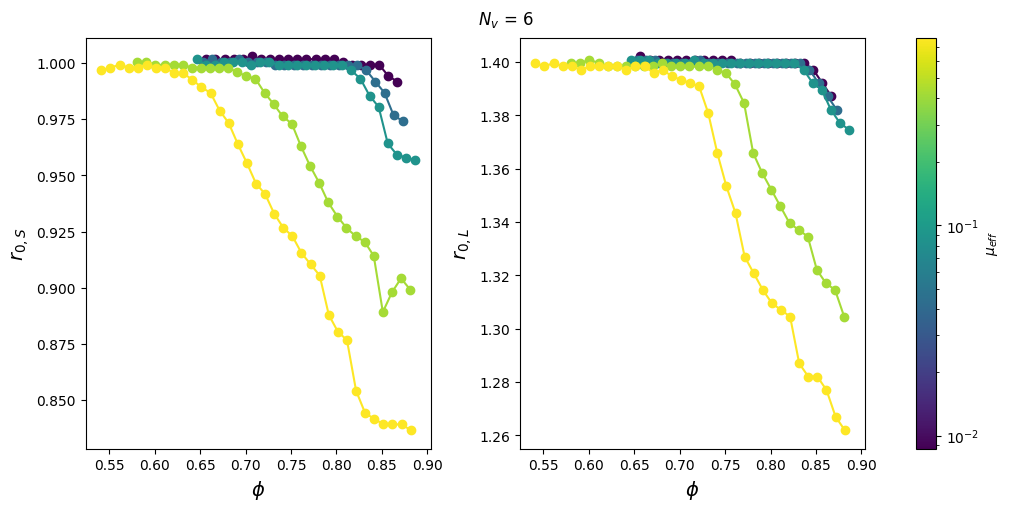

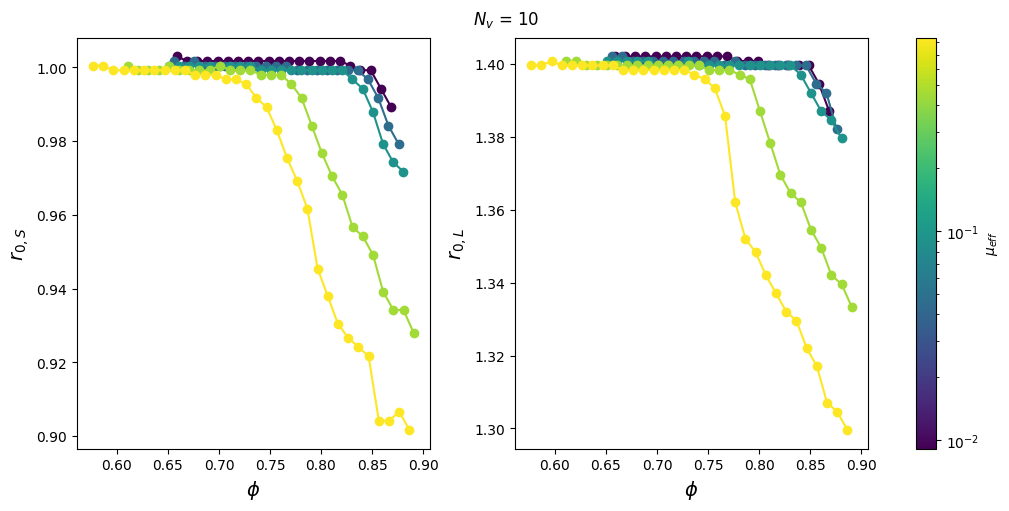

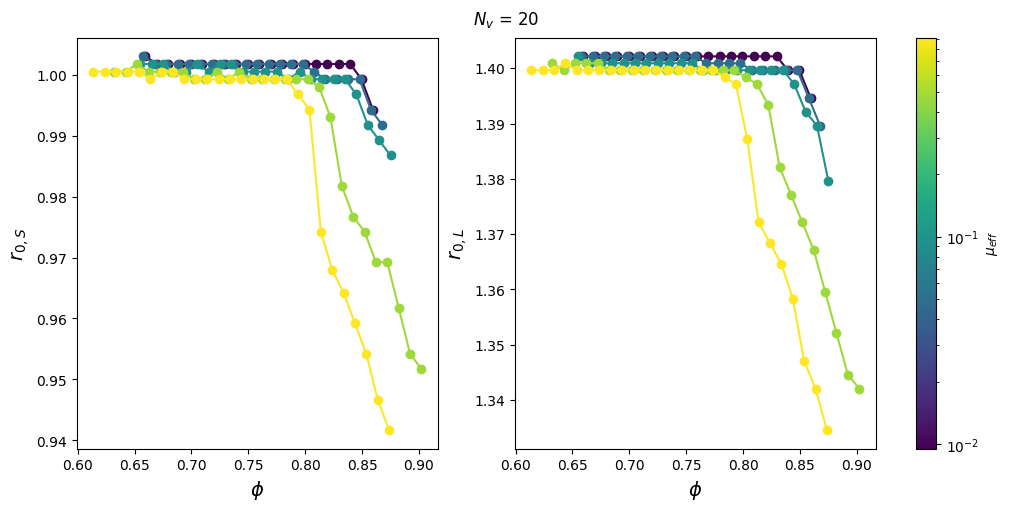

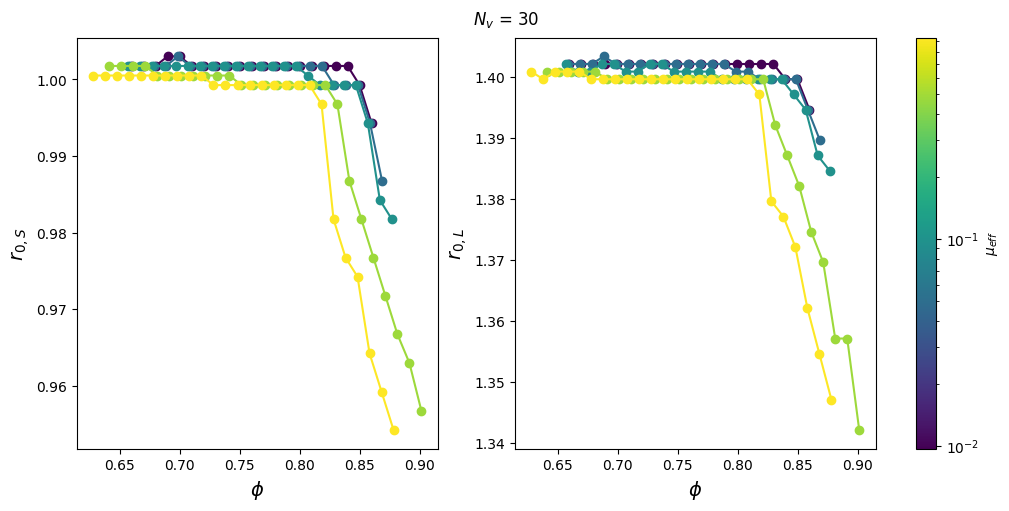

In [308]:
show_phi_b = False

def find_phi_b(r, phi, plateau_length=5, phi_b_cutoff_fraction=0.8):
    # scale r to [0, 1]
    # find where r first deviates from its initial plateau value by more than 1 - phi_b_cutoff_fraction
    r -= r.min()
    r /= r.max()
    low_phi = np.mean(r[:plateau_length])
    phi_b = phi[np.where(r < low_phi * phi_b_cutoff_fraction)[0][0]]
    return phi_b

def find_phi_b_fit(r, phi, plateau_length=10, fit_deviation_cutoff=0.1):
    r -= r.min()
    r /= r.max()
    def obj(X, x, y):
        m, b = X
        return np.sum((y - (m * x + b)) ** 2)
    m, b = minimize(obj, (1, 0), args=(phi[:plateau_length], r[:plateau_length])).x
    fit = m * phi + b
    sr = (r - fit) ** 2
    if np.any(sr > fit_deviation_cutoff):
        phi_b = phi[np.where(sr > fit_deviation_cutoff)[0][0]]
    else:
        phi_b = phi.max()
    return phi_b

for nv in np.unique(system_data.nv):
    mask = system_data.nv == nv
    mu_eff_values = np.unique(system_data[mask].mu_eff)

    cmap = plt.get_cmap('viridis')
    mu_eff_norm = LogNorm(vmin=mu_eff_values.min(), vmax=mu_eff_values.max())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
    for mu_eff in mu_eff_values:
        mask2 = mask & (system_data.mu_eff == mu_eff)
        ax[0].plot(system_data.phi[mask2], system_data.r0_small[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[1].plot(system_data.phi[mask2], system_data.r0_large[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='o')

        # find phi_b for the small and large particles
        if nv > 11:
            plateau_length = 20
            phi_b_cutoff_fraction = 0.5
        else:
            plateau_length = 5
            phi_b_cutoff_fraction = 0.85

        # phi_b_small = find_phi_b(system_data.r0_small[mask2].values, system_data.phi[mask2].values, plateau_length, phi_b_cutoff_fraction)
        phi_b_small = find_phi_b_fit(system_data.r0_small[mask2].values, system_data.phi[mask2].values, plateau_length, 0.1)
        system_data.loc[mask2, 'phi_b_small'] = phi_b_small
        if show_phi_b:
            ax[0].axvline(phi_b_small, c='k', linestyle='--')
        
        # phi_b_large = find_phi_b(system_data.r0_large[mask2].values, system_data.phi[mask2].values, plateau_length, phi_b_cutoff_fraction)
        phi_b_large = find_phi_b_fit(system_data.r0_large[mask2].values, system_data.phi[mask2].values, plateau_length, 0.1)
        system_data.loc[mask2, 'phi_b_large'] = phi_b_large
        if show_phi_b:
            ax[1].axvline(phi_b_large, c='k', linestyle='--')
    for a in ax:
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$r_{0,S}$', fontsize=14)
    ax[1].set_ylabel(r'$r_{0,L}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.savefig(f'figures/gr/{nv-1}.png', dpi=300)
    plt.show()


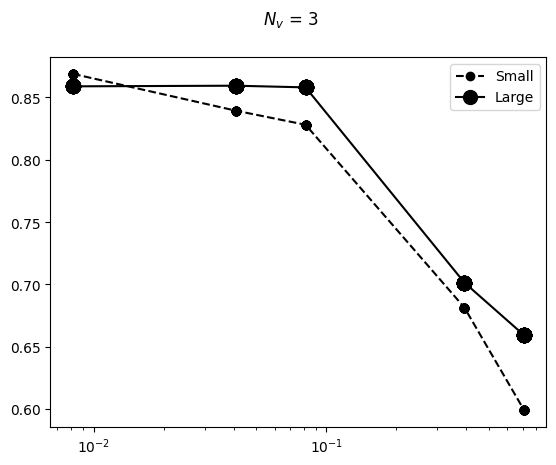

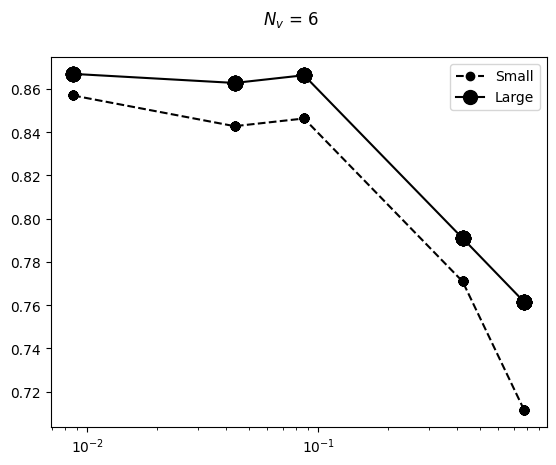

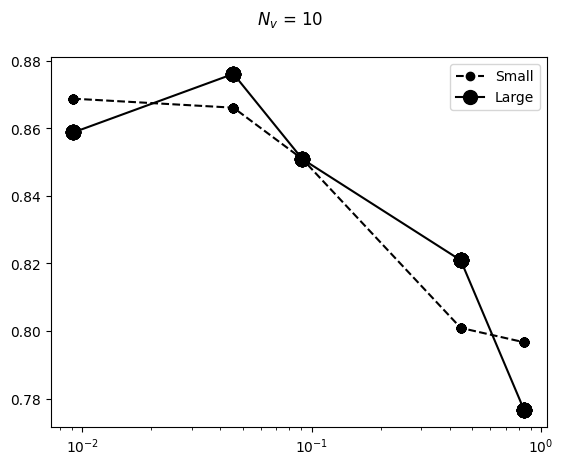

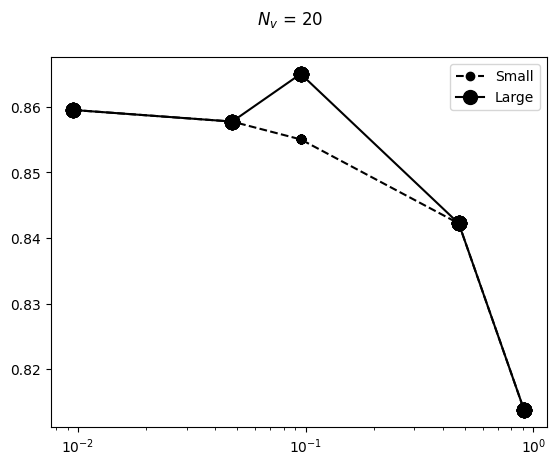

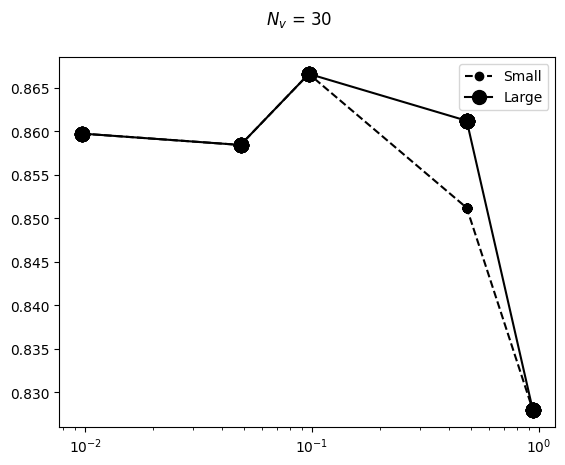

In [309]:
for nv in np.unique(system_data.nv):
    mask = system_data.nv == nv
    mu_eff_values = np.unique(system_data[mask].mu_eff)

    mu_val = system_data.mu_eff[mask].values
    phi_b_small_val = system_data.phi_b_small[mask].values
    phi_b_large_val = system_data.phi_b_large[mask].values
    order = np.argsort(mu_val)
    mu_val = mu_val[order]
    phi_b_small_val = phi_b_small_val[order]
    phi_b_large_val = phi_b_large_val[order]

    plt.plot(mu_val, phi_b_small_val, c='k', marker='o', label='Small', linestyle='--')
    plt.plot(mu_val, phi_b_large_val, c='k', marker='o', label='Large', ms=10)
    plt.xscale('log')
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    plt.legend()
    plt.savefig(f'figures/phi_b/{nv-1}.png', dpi=300)
    plt.show()
